In [1]:
# Varational AutoEncoder (no convolutional layers)
# https://blog.keras.io/building-autoencoders-in-keras.html

In [2]:
import keras
from keras import layers
from keras.datasets import mnist
import numpy as np

2022-09-12 17:52:58.664085: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.

In [5]:
intermediate_dim = 64
latent_dim = 2
img_height = x_train[0].shape[0]
img_width = x_train[0].shape[1]
img_pixels = img_width*img_height
original_dim = img_pixels
print(img_pixels)

784


In [6]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [7]:
print(x_train.shape, x_test.shape)

(60000, 784) (10000, 784)


In [8]:
inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)
#encoded = layers.Dense(encoding_dim, activation="relu")(input_img)
#decoded = layers.Dense(img_pixels, activation="sigmoid")(encoded)
#autoencoder = keras.Model(input_img, decoded)

In [9]:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [10]:
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

In [11]:
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [12]:
#encoded_input = keras.Input(shape=(encoding_dim,))
#decoder_layer = autoencoder.layers[-1]
#decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

In [13]:
#autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

In [14]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [15]:
#autoencoder.fit(x_train, x_train, epochs=20, batch_size=64, shuffle=True, validation_data=(x_test, x_test))
vae.fit(x_train, x_train,
        epochs=10,
        batch_size=32,
        validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 5s 2ms/step - loss: 188.6964 - val_loss: 170.2386
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 167.8934 - val_loss: 164.6816
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 163.4202 - val_loss: 161.4634
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 160.6638 - val_loss: 159.9482
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 159.1423 - val_loss: 158.7155
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 158.0959 - val_loss: 157.8311
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 157.1986 - val_loss: 157.0847
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 156.4551 - val_loss: 156.4075
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 155.7490 - val_loss: 155.8846
Epoch 10/10
1875/1875 [=======================

In [16]:
import matplotlib.pyplot as plt
#encoded_imgs = encoder.predict(x_test)
batch_size = 32
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
print(x_test_encoded[0])

313/313 [==============================] - 0s 1ms/step
[[ 0.26960084 -0.73148453]
 [-0.2197155   0.61350965]
 [ 2.8800344  -0.4394029 ]
 ...
 [ 0.19248655 -0.530257  ]
 [ 0.08479229 -0.02750161]
 [-0.6920863   0.03392562]]


ValueError: 'c' argument has 10000 elements, which is inconsistent with 'x' and 'y' with size 20000.

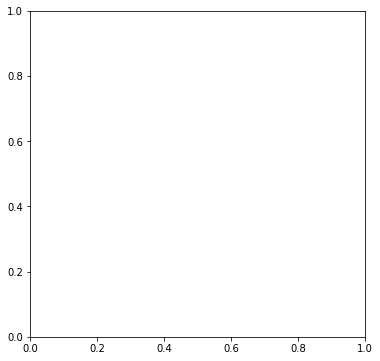

In [17]:
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[0], x_test_encoded[1], c=y_test)
plt.colorbar()
plt.show()

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 16ms/step


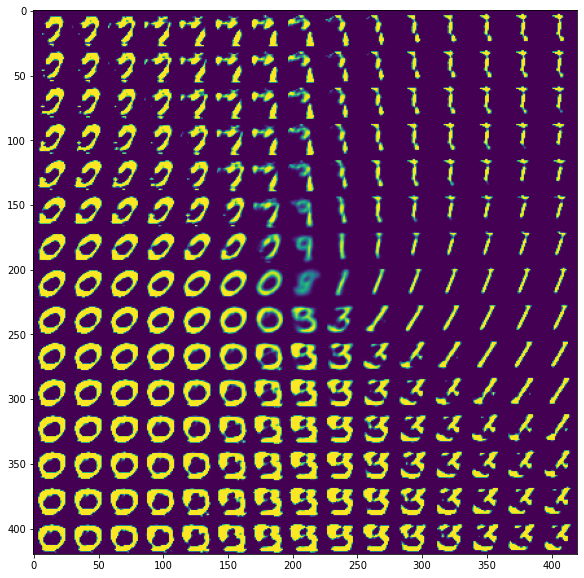

In [18]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()


In [19]:
decoded_imgs = decoder.predict(x_test_encoded)

ValueError: in user code:

    File "/home/vruiz/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "/home/vruiz/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/vruiz/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "/home/vruiz/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1791, in predict_step
        return self(x, training=False)
    File "/home/vruiz/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/vruiz/.local/lib/python3.10/site-packages/keras/engine/input_spec.py", line 200, in assert_input_compatibility
        raise ValueError(f'Layer "{layer_name}" expects {len(input_spec)} input(s),'

    ValueError: Layer "decoder" expects 1 input(s), but it received 3 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 2) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 2) dtype=float32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 2) dtype=float32>]


NameError: name 'decoded_imgs' is not defined

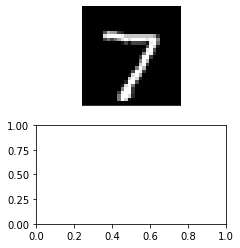

In [20]:
n = 10
plt.figure(figsize=(40,4))
for i in range(n):
  # original
  ax = plt.subplot(2, n, i+1)
  plt.imshow(x_test[i].reshape(img_height, img_width))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  
  # reconstruction
  ax = plt.subplot(2, n, i+1+n)
  plt.imshow(decoded_imgs[i].reshape(imt_height, img_width))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()